<a href="https://colab.research.google.com/github/EmilisGit/Deep_learning/blob/main/bert_finetuning_with_transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers datasets -q

In [2]:
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import transformers
import os

from transformers import AutoTokenizer, AutoModelForCausalLM
print("Transformers " + transformers.__version__)

Transformers 4.46.3


In [3]:
#@title Import Dataset

hfDataset = load_dataset("antash420/text-summarization-alpaca-format")
hfDataset.save_to_disk("/content/hfDataset")

print("Input: ", hfDataset['test']['input'][0])
print("Output: ", hfDataset['test']['output'][0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Saving the dataset (0/6 shards):   0%|          | 0/287113 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/13368 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/11490 [00:00<?, ? examples/s]

Input:  (CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC's founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday's cere

In [4]:
from transformers import pipeline

summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-6-6")

res = summarizer(hfDataset['test']['input'][0])
print(res)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


[{'summary_text': ' The Palestinian Authority officially becomes the 123rd member of the International Criminal Court . The move gives the court jurisdiction over alleged crimes in Palestinian territories . Israel and the United States, neither of which is an ICC member, opposed the Palestinians\' efforts to join the body . The United States says it "strongly" disagreed with the court'}]


In [5]:
len(res[0]['summary_text'])

367

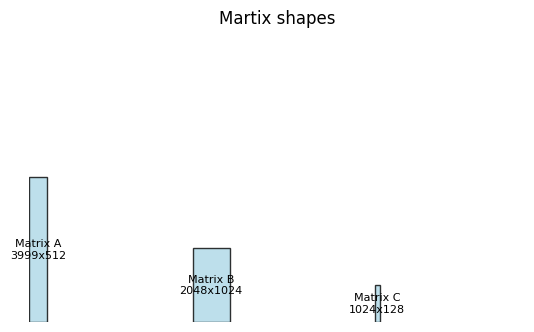

In [6]:
#@title Plot Matrices
def plot_matrices(matrices, labels=None, max_height=10, max_width=10):
    """
    Visualizes the shapes of large NumPy matrices as scaled rectangles.

    Parameters:
    - matrices: List of NumPy arrays
    - labels: Optional list of labels for the matrices
    - max_height: Maximum height of the largest rectangle in the plot
    - max_width: Maximum width of the largest rectangle in the plot
    """
    fig, ax = plt.subplots()
    current_x = 0

    # Determine scaling factors
    max_rows = max(matrix.shape[0] for matrix in matrices)
    max_cols = max(matrix.shape[1] for matrix in matrices)
    scale = max(max_rows, max_cols)

    for i, matrix in enumerate(matrices):
        rows, cols = matrix.shape
        scaled_rows = rows / scale
        scaled_cols = cols / scale

        # Draw rectangle
        rect = plt.Rectangle(
            (current_x, 0), scaled_cols, scaled_rows, edgecolor='black', facecolor='lightblue', alpha=0.8
        )
        ax.add_patch(rect)

        # Add label
        if labels and i < len(labels):
            ax.text(
                current_x + scaled_cols / 2, scaled_rows / 2,
                f"{labels[i]}\n{rows}x{cols}", ha='center', va='center', fontsize=8
            )

        current_x += scaled_cols + 1  # Add space between matrices

    # Set limits and display
    ax.set_xlim(0, current_x)
    ax.set_ylim(0, max(matrix.shape[0] / scale for matrix in matrices) + 1)
    ax.set_aspect('equal')
    ax.axis('off')
    plt.xlabel('Columns (scaled)')
    plt.ylabel('Rows (scaled)')
    plt.title('Martix shapes')
    plt.show()

# Example usage with large matrices
matrices = [
    np.random.rand(3999, 512),
    np.random.rand(2048, 1024),
    np.random.rand(1024, 128)
]
labels = ["Matrix A", "Matrix B", "Matrix C"]
plot_matrices(matrices, labels)


In [28]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("google/t5-efficient-small")
model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-efficient-small")

input_text = hfDataset['test']['input'][0]

inputs = tokenizer(
    input_text,
    return_tensors="pt",
    padding="max_length",
    max_length=512,  # Ensure it fits within the model's maximum context size
    truncation=True
)

summary_ids = model.generate(
    inputs["input_ids"],
    max_length=128,
    min_length=40,   # Min length of the summary
    length_penalty=2.0,
    num_beams=4,     # Beam search for better summaries
    early_stopping=True
)

# Decode the generated summary
summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)

print("Summary:", summary)

Summary: the ICC today announced it would join the ICC today. The ICC today announced it would join the ICC today. the ICC today announced it would join the ICC today. the ICC today announced it would join the ICC today. the ICC today announced it would join the ICC today. the ICC today the ICC.. the.. " ICC a step closer to the ICC," he said.


In [39]:
type(model)

transformers.models.t5.modeling_t5.T5ForConditionalGeneration

Kiek turime apmokymo duomenų (mėginių)?

In [8]:
print("Apmokymo duomenu: ", len(hfDataset['train']))
print("Testavimo duomenu: ", len(hfDataset['test']))

Apmokymo duomenu:  287113
Testavimo duomenu:  11490


Toliau naudosime tik dalį atsiliepimų viso proceso greitinimui:

In [29]:
n_samples = 600
small_train_dataset = hfDataset["train"].shuffle(seed=42).select(range(n_samples))
small_eval_dataset = hfDataset["test"].shuffle(seed=42).select(range(n_samples//2))
len(small_eval_dataset)

300

In [30]:
def tokenize(text):
  inputs = tokenizer(
      text['text'], max_length=1024, truncation=True, padding="max_length", return_tensors="tf",
  )
  outputs = tokenizer(
      text["output"], max_length=128, truncation=True, padding="max_length", return_tensors="tf"
  )

  tokens = inputs
  tokens["labels"] = outputs["input_ids"]
  return inputs


encoded_train = small_train_dataset.map(tokenize, batched=True)
encoded_eval = small_eval_dataset.map(tokenize, batched=True)

Map:   0%|          | 0/600 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [31]:
encoded_train.remove_columns(["id", "output", "input", "instruction", "text"])
encoded_eval.remove_columns(["id", "output", "input", "instruction", "text"])

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 300
})

Pastebekime kad po tokenizavimo mūsų `Dataset` objectas gavo naujas savybes (stulpelius, raktažodžius) - `'input_ids'`, `'token_type_ids'` ir `'attention_mask'`:

In [32]:
len(encoded_train[0]['labels'])

128

In [13]:
# plot_matrices([np.matrix(encoded_train['input_ids']),
#                np.matrix(encoded_train['labels']),
#                np.matrix(encoded_eval['input_ids']),
#                np.matrix(encoded_eval['labels'])],
#               ["train_input_ids",
#                "train_output_ids",
#                "eval_input_ids",
#                "eval_output_ids"])

Paruošiame klasifikavimo žymių žodynus:

## 2. Modelio inicializavimas ir derinimas

In [33]:
# from transformers import DataCollatorForSeq2Seq

# data_collator = DataCollatorForSeq2Seq(
#     tokenizer,
#     model=model,
#     label_pad_token_id=tokenizer.pad_token_id,
#     pad_to_multiple_of=8,
#     return_tensors="np"
# )

# tf_train_dataset = model.prepare_tf_dataset(
#     encoded_train,
#     collate_fn=data_collator,
#     shuffle=True,
#     batch_size=16,
# )

# tf_eval_dataset = model.prepare_tf_dataset(
#     encoded_eval,
#     collate_fn=data_collator
# )

AttributeError: 'T5ForConditionalGeneration' object has no attribute 'prepare_tf_dataset'

Ką tik gautas įspėjimas apie kai kuriuos išmestus svorius yra normalus - šiuo atveju mes pašalinome modelio bloką, atsakingą už maskuotą kalbos modeliavimą - tai yra įprasta BERT modelio užduotis, o mes norime atlikti sentimentų analizę (teksto klasifikavimą), dėl ko mums ir reikia papildomas modelio derinimas.

Norime įkelsti mūsų duomenis kaip Tensorflow duomenų rinkinius - tai bus padaryta automatiškai ir atitiks modelio architektūrą:

In [15]:
!pip install evaluate -q

In [16]:
# import numpy as np
# import evaluate

# metric = evaluate.load("accuracy")
# def compute_metrics(eval_pred):
#     logits, labels = eval_pred
#     predictions = np.argmax(logits, axis=-1)
#     return metric.compute(predictions=predictions, references=labels)

Visi `transformers` modeliai pagal nutylėjimą gali patys pasirinkti protingą nuostolių funkciją, todėl mums nereikis dėti `loss` parametro į `compile()`. Tuo metu `transformers` rekomenduoja sukonstruoti `AdamW` tipo optimizatorių patiems:

In [17]:
# import torch
# torch.cuda.empty_cache()

# from transformers import TrainingArguments, Trainer

# training_args = TrainingArguments(
#     output_dir="test_trainer",
#     eval_strategy="epoch",
#     report_to="none",
#     num_train_epochs=1,
#     per_device_train_batch_size=4,
#     fp16=True,
# )

# trainer = Trainer(
#     model=model,
#     args=training_args,
#     train_dataset=encoded_train,
#     eval_dataset=encoded_eval,
#     compute_metrics=compute_metrics
# )

# trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch,Training Loss,Validation Loss


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (2, 300) + inhomogeneous part.

Laikas fittinti modelį:

In [41]:
num_epochs = 1
batch_size = 4

batches_per_epoch = len(encoded_train) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = transformers.create_optimizer(
    init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
)

model.compile(optimizer=optimizer, metrics=['accuracy'])

model.fit(
  training_data=encoded_train,
  validation_data=encoded_eval,
  epochs=num_epochs,
)

#model.save_pretrained("/content/drive/My Drive/Colab/t5-text-summarization.h5")

TypeError: compile() got an unexpected keyword argument 'optimizer'

## 3. Modelio panaudojimas

In [ ]:
test_text = hfDataset['test'][0]
inference_text = tokenizer(test_text['input'], return_tensors="tf", max_length=512, padding="max_length", truncation=True)
#print(test_text['output'])

outputs = model.generate(
    input_ids=inference_text["input_ids"],
    attention_mask=inference_text["attention_mask"],
    max_length=128,
    num_beams=4,
    early_stopping=True
)

generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(generated_text)

In [ ]:
outputs[0]